In [1]:
from __future__ import division
import pandas as pd
import time
import matplotlib.pyplot as plt
import random
import scipy.stats as st
import numpy as np
import seaborn as sns
import random 
from mpl_toolkits.mplot3d import Axes3D
import statsmodels
import warnings
import math
import sklearn.preprocessing as pp
from scipy.stats import ks_2samp
warnings.filterwarnings('ignore')

In [2]:
pair_colors = {"fix":"#F56416", "random":"#FDCA40", "weak":"#C03221"}
pair_symbols = {"fix":"D", "random":"o", "weak":"s"}

m_colors = {1:"#8AC926", 2:"#022175", "c":"#1982C4"}
m_symbols = {1:"^", 2:"v", "c":"s"}

vn_colors = {"info":"#004E98", "no info": "#EA0F0B"}
vn_symbols = {"info": "d", "no info": "s"}

ddm_params = {"a": "Threshold","v": "Drift Speed","z": "Bias"}

plt.rcParams.update({'font.size': 18})

In [3]:
def normalize_payoff(R, T, S, P):
    j = np.max(np.abs([R, T, S, P])) + 1
    R += j
    S += j
    T += j
    P += j
    T_ = T
    R /= T_
    S /= T_
    T /= T_
    P /= T_
    return [R, T, S, P]

In [4]:
def get_RA(data, N, R, T, S, P, normalize = True):
    #"'Computes the Relative Allocation measure'
    #'data: the raw experimental data
    #'N: neighbourhood size, for Von Neumann = 4, Moore = 6, Pairwise = 1'
    #'R, S, T, P are the parameters of the prisoners dilemma'
    #'returns the dataframe with the RA'"
    if normalize:
        R, T, S, P = pp.minmax_scale([R, T, S, P])
    data["self"] = 0.0
    data["other"] = 0.0
    for u in data["user_id"].unique():
        f_data = data.loc[(data.user_id == u)]
        for r in sorted(f_data["round"].unique()):
            self = 0.0
            other = 0.0
            context = f_data.loc[f_data["round"] == r, "context"].item()
            if (f_data.loc[f_data["round"] == r, "response"].item() == 1):
                self = (R * context) + (S * (N - context))
                other = (R * context) + (T * (N - context))
            else:
                self = (T * context) + (P * (N - context))
                other = (S * context) + (P * (N - context))
            data.loc[(data.user_id == u) & (data["round"] == r), "self"] = self
            data.loc[(data.user_id == u) & (data["round"] == r), "other"] = other
    return data


In [5]:
def cart2pol(x, y, sub = 0):
    rho = np.ones(len(x)) - sub
    phi = np.arctan2(y, x) 
    return(rho, phi)

In [6]:
def RA_rounds(data, pivot, min_round, max_round):
    ra_piv = pd.pivot_table(data.loc[(data["round"] <= max_round) & (data["round"] >= min_round)], values=["self", "other"], index=["user_id"], aggfunc=np.mean).reset_index()
    ra_piv["degrees_%d_%d" % (min_round, max_round)] = np.arctan((ra_piv["other"] / ra_piv["self"]) ) * 180.0 / math.pi
    pivot = pd.merge(pivot, ra_piv[["user_id", "degrees_%d_%d" % (min_round, max_round)]], on = "user_id")
    return pivot

In [7]:
vn_data = pd.read_csv("./data/vnNIPD/vnNIPD.csv")
vn_data_i = vn_data.loc[vn_data.treatment == "info"]
vn_data_n = vn_data.loc[vn_data.treatment == "no info"]
vn_data_i = get_RA(vn_data_i,4,5.0,6.0,1.0,0.0)
vn_data_n = get_RA(vn_data_n,4,5.0,6.0,1.0,0.0)

In [8]:
m_data_1 = pd.read_csv("./data/mNIPD/data1.csv")
m_data_2 = pd.read_csv("./data/mNIPD/data2.csv")
m_data_c = pd.read_csv("./data/mNIPD/dataC.csv")

In [9]:
m_data_1 = get_RA(m_data_1,8,7.0,10.0,0.0,0.0)
m_data_2 = get_RA(m_data_2,8,7.0,10.0,0.0,0.0)
m_data_c = get_RA(m_data_c,8,7.0,10.0,0.0,0.0)

In [10]:
p_data = pd.read_csv("./data/PIPD/PIPD.csv")
p_data_f = p_data.loc[p_data.treatment == "fix"]
p_data_c = p_data.loc[p_data.treatment == "changing"]
p_data_f = get_RA(p_data_f,1,3.0,4.0,1.0,0.0)
p_data_c = get_RA(p_data_c,1,3.0,4.0,1.0,0.0)


In [11]:
ddm_fix = pd.read_csv("./data/PIPD/ddm_params_fix.csv")
ddm_rand = pd.read_csv("./data/PIPD/ddm_params_ch.csv")

ddm_vn = pd.read_csv("./data/vnNIPD/ddm_params.csv")

ddm_m1 = pd.read_csv("./data/mNIPD/ddm_params_1.csv")
ddm_m2 = pd.read_csv("./data/mNIPD/ddm_params_2.csv")

In [12]:
ra_fix = pd.pivot_table(p_data_f.loc[p_data_f["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)
ra_rand = pd.pivot_table(p_data_c.loc[p_data_c["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)

In [13]:
ra_m1 = pd.pivot_table(m_data_1.loc[m_data_1["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)
ra_m2 = pd.pivot_table(m_data_2.loc[m_data_2["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)

In [14]:
ra_vnI = pd.pivot_table(vn_data_i.loc[vn_data_i["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)
ra_vnN = pd.pivot_table(vn_data_n.loc[vn_data_n["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)

In [15]:
ra_fix["degrees"] = np.arctan((ra_fix["other"] / ra_fix["self"]) ) * 180.0 / math.pi
ra_rand["degrees"] = np.arctan((ra_rand["other"] / ra_rand["self"]) ) * 180.0 / math.pi

In [16]:
ra_vnI["degrees"] = np.arctan((ra_vnI["other"] / ra_vnI["self"]) ) * 180.0 / math.pi
ra_vnN["degrees"] = np.arctan((ra_vnN["other"] / ra_vnN["self"]) ) * 180.0 / math.pi

In [17]:
ra_m1["degrees"] = np.arctan((ra_m1["other"] / ra_m1["self"]) ) * 180.0 / math.pi
ra_m2["degrees"] = np.arctan((ra_m2["other"] / ra_m2["self"]) ) * 180.0 / math.pi

In [18]:
ra_fix = ra_fix.merge(ddm_fix, on= "user_id")
ra_rand = ra_rand.merge(ddm_rand, on= "user_id")

ra_vnI = ra_vnI.merge(ddm_vn, on= "user_id")
ra_vnN = ra_vnN.merge(ddm_vn, on= "user_id")

ra_m1 = ra_m1.merge(ddm_m1, on= "user_id")
ra_m2 = ra_m2.merge(ddm_m2, on= "user_id")

In [19]:
ra_fix = RA_rounds(p_data_f, ra_fix, 80, 100)
ra_fix = RA_rounds(p_data_f, ra_fix, 40, 60)

In [20]:
ra_rand = RA_rounds(p_data_c, ra_rand, 80, 100)
ra_rand = RA_rounds(p_data_c, ra_rand, 40, 60)
ra_rand

,user_id,other,self,degrees,Unnamed: 0,a,v,t,z,a_sd,v_sd,t_sd,z_sd,degrees_80_100,degrees_40_60
0,s11n9_usuario1,0.4750,0.4000,49.899092,12800,2.676536,-0.269466,0.319204,0.410576,0.126422,0.099092,0.041532,0.036750,30.379126,35.537678
1,s11n9_usuario10,0.3000,0.3375,41.633539,12809,3.857674,-0.545169,0.549688,0.313018,0.307482,0.093902,0.048030,0.038201,14.036243,14.036243
2,s11n9_usuario2,0.3500,0.3500,45.000000,12801,2.018543,-0.356021,0.458011,0.452134,0.100568,0.124099,0.031881,0.035113,66.370622,45.000000
3,s11n9_usuario3,0.3875,0.2375,58.495733,12802,2.635994,-0.246632,0.390122,0.466386,0.123761,0.095731,0.049083,0.034704,45.000000,61.699244
4,s11n9_usuario4,0.4000,0.3250,50.906141,12803,2.940271,0.112610,0.167399,0.429343,0.119676,0.075085,0.048649,0.029690,45.000000,57.994617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,s7m22_usuario5,0.1125,0.2625,23.198591,6604,2.184519,-0.341192,0.239900,0.370948,0.108407,0.123406,0.031422,0.037508,49.899092,48.990913
92,s7m22_usuario6,0.2125,0.2875,36.469234,6605,4.597500,-0.560312,0.392790,0.292790,0.407908,0.086208,0.054699,0.037813,14.036243,14.036243
93,s7m22_usuario7,0.4125,0.3375,50.710593,6606,3.780060,-0.068224,0.034090,0.431295,0.114706,0.048161,0.015658,0.025225,45.000000,39.093859
94,s7m22_usuario8,0.2375,0.3500,34.159695,6607,3.833465,-0.047882,0.172108,0.627903,0.153044,0.059998,0.051614,0.029901,73.412661,66.801409


In [21]:
ra_vnN = RA_rounds(vn_data_n, ra_vnN, 30, 59)
ra_vnN = RA_rounds(vn_data_n, ra_vnN, 20, 40)
ra_vnN

,user_id,other,self,degrees,Unnamed: 0,a,v,t,z,a_sd,v_sd,t_sd,z_sd,degrees_30_59,degrees_20_40
0,usuario10_nets4m10,3.650000,1.233333,71.329912,1100,2.860927,0.449137,0.252250,0.501836,0.192752,0.124803,0.070939,0.046836,66.037511,74.054604
1,usuario10_nets5m10,0.391667,1.266667,17.182159,7000,2.780232,-0.444142,0.469068,0.568382,0.194565,0.128966,0.081110,0.044853,49.085617,63.745492
2,usuario10_nets6m10,2.016667,1.766667,48.780569,2850,3.515053,-0.073376,0.779934,0.485427,0.233236,0.096558,0.152235,0.046072,58.656349,38.699487
3,usuario10_nets7m11,1.333333,1.916667,34.824489,3200,6.421839,-0.075711,0.439726,0.489810,0.358729,0.050094,0.194162,0.044790,34.674742,32.635944
4,usuario11_nets4m10,0.783333,1.450000,28.379243,2250,5.866247,-0.346322,0.506309,0.464042,0.445867,0.071131,0.214509,0.053033,18.434949,9.462322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,usuario8_nets7m11,0.533333,1.033333,27.299572,4450,6.629712,-0.251821,0.573283,0.514308,0.437592,0.057814,0.263165,0.050305,41.185925,45.000000
60,usuario9_nets4m10,2.033333,1.366667,56.093723,2950,2.629808,-0.071900,1.173954,0.446522,0.183391,0.134566,0.085839,0.049098,38.254420,47.504051
61,usuario9_nets5m10,0.408333,1.533333,14.912034,3900,4.244680,-0.467649,0.248280,0.267456,0.448884,0.111625,0.053851,0.041788,9.462322,9.462322
62,usuario9_nets6m10,1.833333,1.750000,46.332220,350,3.408424,-0.038200,0.629402,0.512273,0.224546,0.102731,0.119206,0.047247,44.460508,36.869898


In [22]:
ra_vnI = RA_rounds(vn_data_i, ra_vnI, 30, 50)
ra_vnI = RA_rounds(vn_data_i, ra_vnI, 20, 40)
ra_vnI

,user_id,other,self,degrees,Unnamed: 0,a,v,t,z,a_sd,v_sd,t_sd,z_sd,degrees_30_50,degrees_20_40
0,usuario10_nets1m3,1.725000,0.933333,61.583828,400,4.921943,-0.069959,0.499733,0.448241,0.298230,0.067665,0.183324,0.045945,67.922801,64.754026
1,usuario10_nets2m3,1.658333,1.950000,40.378749,6950,6.377162,-0.039010,0.594301,0.484938,0.363093,0.052656,0.275034,0.045512,40.352029,41.185925
2,usuario10_nets3m3,1.516667,1.266667,50.132554,5300,7.114845,-0.259296,0.640066,0.565332,0.474427,0.056890,0.308481,0.048430,22.533250,29.638384
3,usuario10_nets8m11,2.225000,1.516667,55.719782,1750,4.249900,-0.005717,0.380507,0.547481,0.244350,0.073964,0.131452,0.042927,62.121808,61.955313
4,usuario10_nets9m11,1.033333,1.783333,30.089686,6050,2.772463,-0.121236,1.237069,0.441190,0.187966,0.127176,0.096904,0.048116,41.303858,59.088283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,usuario9_nets1m3,2.208333,1.416667,57.319445,1900,7.787984,0.000052,0.606532,0.539540,0.458541,0.044034,0.298590,0.048066,58.948858,52.141079
76,usuario9_nets2m3,0.625000,1.416667,23.805944,3050,7.096636,-0.153097,0.372729,0.392673,0.444711,0.049021,0.161049,0.042922,38.047043,28.774725
77,usuario9_nets3m3,1.683333,1.683333,45.000000,4950,4.477797,-0.201940,0.900928,0.557078,0.316250,0.078759,0.268757,0.045568,45.000000,44.210852
78,usuario9_nets8m11,0.516667,2.016667,14.370002,2100,6.009177,-0.518277,0.373729,0.514229,0.499354,0.079588,0.148652,0.053944,9.462322,9.462322


In [23]:
ra_m1 = RA_rounds(m_data_1, ra_m1, 40, 60)
ra_m1 = RA_rounds(m_data_1, ra_m1, 20, 40)
ra_m1

,user_id,other,self,degrees,Unnamed: 0,a,v,t,z,a_sd,v_sd,t_sd,z_sd,degrees_40_60,degrees_20_40
0,1,0.405263,3.563158,6.488770,3002,4.872060,-0.481160,0.573915,0.551031,0.384381,0.092994,0.208332,0.053805,0.000000,27.447748
1,2,3.457895,2.352632,55.769988,513,3.679075,-0.008819,0.682316,0.519148,0.256155,0.095220,0.167856,0.046246,67.227569,60.932303
2,3,1.963158,2.226316,41.405741,3938,4.925077,-0.318525,0.817822,0.519119,0.371848,0.082520,0.275595,0.053152,33.690068,45.000000
3,4,3.084211,1.873684,58.720962,6590,3.815628,-0.158025,1.479527,0.520373,0.296470,0.099959,0.225575,0.052364,53.488944,65.800622
4,5,1.447368,2.921053,26.358208,560,5.325109,-0.256453,0.795262,0.622768,0.366140,0.075242,0.272943,0.046720,61.531081,53.254186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,165,1.573684,1.994737,38.270551,4861,3.522439,-0.311563,1.330258,0.519484,0.281133,0.110714,0.191108,0.053285,45.000000,56.136309
165,166,3.036842,2.563158,49.834938,607,5.120226,-0.063647,1.375713,0.525291,0.409953,0.072634,0.552563,0.050047,62.427143,59.088283
166,167,1.168421,2.957895,21.554902,1969,4.395841,-0.509297,0.363096,0.552455,0.335769,0.102375,0.117122,0.053074,0.000000,26.821981
167,168,7.168421,1.010526,81.975935,4955,5.814813,0.399094,0.840707,0.409354,0.458341,0.077141,0.371790,0.051265,83.453709,82.375807


In [24]:
ra_m2 = RA_rounds(m_data_2, ra_m2, 30, 47)
ra_m2 = RA_rounds(m_data_2, ra_m2, 20, 30)
ra_m2

,user_id,other,self,degrees,Unnamed: 0,a,v,t,z,a_sd,v_sd,t_sd,z_sd,degrees_30_47,degrees_20_30
0,1,0.826316,1.563158,27.861805,7979,4.072660,-0.773147,0.773442,0.468269,0.410898,0.126068,0.151123,0.064026,0.000000,0.000000
1,2,3.426316,2.110526,58.367952,4092,3.232845,-0.061625,1.290614,0.392963,0.206207,0.104110,0.110907,0.045986,57.528808,48.972496
2,3,0.000000,1.526316,0.000000,1777,5.143699,-0.685028,0.119172,0.438574,0.567455,0.098237,0.043297,0.055892,0.000000,0.000000
3,4,0.794737,1.321053,31.030848,4266,4.365000,-0.735081,1.220471,0.583976,0.453183,0.112206,0.282794,0.056331,14.534455,0.000000
4,5,4.547368,2.389474,62.279737,4614,3.240138,-0.142445,1.136097,0.574559,0.202827,0.102851,0.104792,0.043511,66.127373,65.117801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,165,0.000000,1.894737,0.000000,1083,2.905395,-0.515844,1.070403,0.447969,0.221807,0.132785,0.089431,0.054697,62.422250,0.000000
165,166,2.384211,1.436842,58.924773,7753,4.548275,-0.124115,1.049499,0.457787,0.308813,0.076911,0.270960,0.050148,64.102011,70.114835
166,167,0.810526,1.705263,25.422145,8499,3.854057,-1.173411,0.757904,0.628639,0.371803,0.159188,0.122366,0.056239,0.000000,0.000000
167,168,7.016667,2.294444,71.892296,2414,9.730135,0.398140,0.439027,0.393278,0.736740,0.052685,0.212691,0.048807,76.061884,74.107685


In [25]:
pd.cut(ra_fix.degrees, [-1, 10, 20, 30,40,50,60,70,80,90]).value_counts()

(40, 50]    29
(50, 60]    13
(30, 40]    11
(60, 70]     2
(10, 20]     1
(20, 30]     1
(70, 80]     1
(-1, 10]     0
(80, 90]     0
Name: degrees, dtype: int64

In [39]:
pd.cut(ra_rand.degrees, [-1, 10, 20, 30,40,50,60,70,80,90]).value_counts()

(40, 50]    22
(50, 60]    19
(60, 70]    16
(30, 40]    15
(20, 30]    13
(10, 20]    11
(-1, 10]     0
(70, 80]     0
(80, 90]     0
Name: degrees, dtype: int64

In [27]:
pd.cut(ra_m1.degrees, [-1, 10, 20, 30,40,50,60,70,80,90]).value_counts()

(40, 50]    35
(-1, 10]    27
(50, 60]    25
(30, 40]    22
(60, 70]    21
(20, 30]    19
(70, 80]    10
(10, 20]     8
(80, 90]     2
Name: degrees, dtype: int64

In [28]:
pd.cut(ra_m2.degrees, [-1, 10, 20, 30,40,50,60,70,80,90]).value_counts() 

(-1, 10]    52
(60, 70]    23
(70, 80]    23
(10, 20]    15
(40, 50]    15
(50, 60]    15
(20, 30]    12
(30, 40]    11
(80, 90]     3
Name: degrees, dtype: int64

In [36]:
#pd.cut(ra_vnI.degrees, [0, 10, 20, 30,40,50,60,70,80,90]).value_counts() / len(ra_vnN)
pd.cut(ra_vnI.degrees, [0, 10, 20, 30,40,50,60,70,80,90]).value_counts()

(50, 60]    25
(40, 50]    20
(30, 40]    11
(20, 30]    10
(60, 70]     8
(0, 10]      4
(10, 20]     2
(70, 80]     0
(80, 90]     0
Name: degrees, dtype: int64

In [44]:
pd.cut(ra_vnN.degrees, [0, 10, 20, 30,40,50,60,70,80,90]).value_counts()

(40, 50]    15
(50, 60]    15
(30, 40]    12
(20, 30]     8
(60, 70]     6
(0, 10]      3
(10, 20]     3
(70, 80]     2
(80, 90]     0
Name: degrees, dtype: int64

In [59]:
len(ra_m2.loc[ra_m2.degrees.between(0,10)])

52

In [44]:
ra_rand.v.mean()

-0.2783624426798431


# Charts


In [25]:
r_fix, theta_fix = cart2pol(ra_fix.self, ra_fix.other, 0.2)
r_chang, theta_chang = cart2pol(ra_rand.self, ra_rand.other, 0.3)

In [26]:
r_vnI, theta_vnI = cart2pol(ra_vnI.self, ra_vnI.other, 0.2)
r_vnN, theta_vnN = cart2pol(ra_vnN.self, ra_vnN.other, 0.3)

In [27]:
r_m1, theta_m1 = cart2pol(ra_m1.self, ra_m1.other, 0.2)
r_m2, theta_m2 = cart2pol(ra_m2.self, ra_m2.other, 0.3)

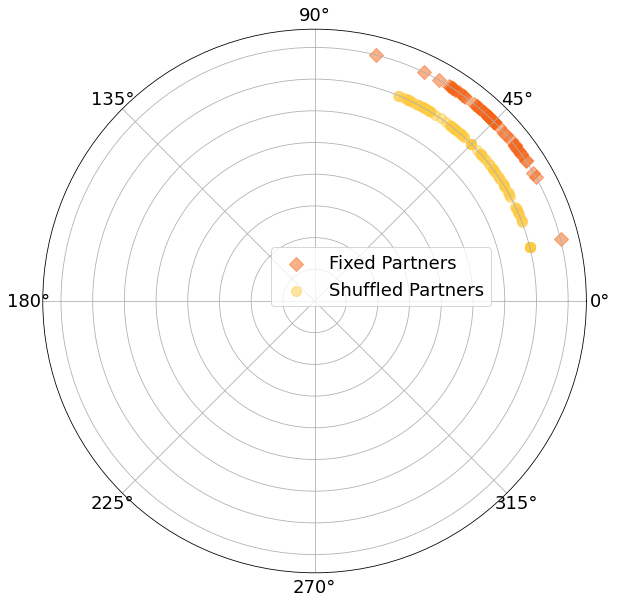

In [28]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta_fix, r_fix, s = 100, color = pair_colors["fix"], marker = pair_symbols["fix"], cmap='hsv', alpha=0.5, label = "Fixed Partners")
c = ax.scatter(theta_chang, r_chang, s = 100, color = pair_colors["random"], marker = pair_symbols["random"], cmap='hsv', alpha=0.5, label = "Shuffled Partners")
ax.scatter(theta_fix, [0.85] * 58, alpha = 0)
ax.set_yticklabels([])
plt.legend(loc = (0.42,0.49))
plt.savefig('./images/polar_pair.svg', format='svg', dpi=300, bbox_inches='tight')


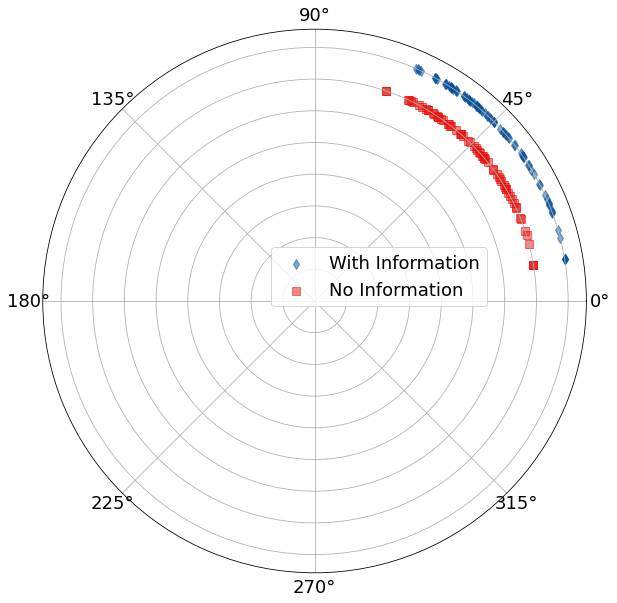

In [29]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta_vnI, r_vnI, s = 50, color = vn_colors["info"], marker = vn_symbols["info"], cmap='hsv', alpha=0.5, label = "With Information")
c = ax.scatter(theta_vnN, r_vnN, s = 50, color = vn_colors["no info"], marker = vn_symbols["no info"], cmap='hsv', alpha=0.5, label = "No Information")
ax.scatter(theta_vnI, [0.85] * 80, alpha = 0)
ax.set_yticklabels([])
plt.legend(loc = (0.42,0.49))
plt.savefig('./images/polar_vn.svg', format='svg', dpi=300, bbox_inches='tight')

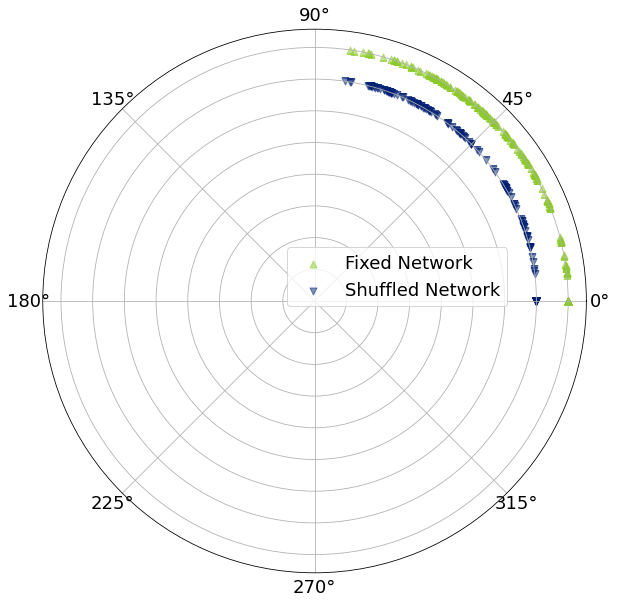

In [30]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta_m1, r_m1, s = 50, color = m_colors[1], marker = m_symbols[1], cmap='hsv', alpha=0.5, label = "Fixed Network")
c = ax.scatter(theta_m2, r_m2, s = 50, color = m_colors[2], marker = m_symbols[2], cmap='hsv', alpha=0.5, label = "Shuffled Network")
ax.scatter(theta_m1, [0.85] * 169, alpha = 0)
ax.set_yticklabels([])
plt.legend(loc = (0.45,0.49))
plt.savefig('./images/polar_m.svg', format='svg', dpi=300, bbox_inches='tight')

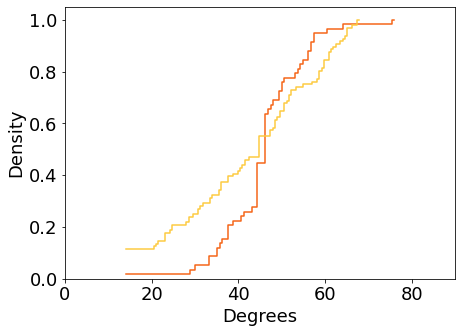

In [31]:
plt.figure(figsize=(7,5))
sns.histplot(
    data=ra_fix, x="degrees", element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, 
    color = pair_colors["fix"], label = "Fixed Partners", bins = 100
)

sns.histplot(
    data=ra_rand, x="degrees", element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, 
    color = pair_colors["random"], label = "Shuffled Partners", 
    bins = 100
)
#plt.legend(loc = "upper left")
plt.xlim(0,90)
plt.xlabel("Degrees")
plt.savefig('./images/cum_ra_pair.svg', format='svg', dpi=300, bbox_inches='tight')

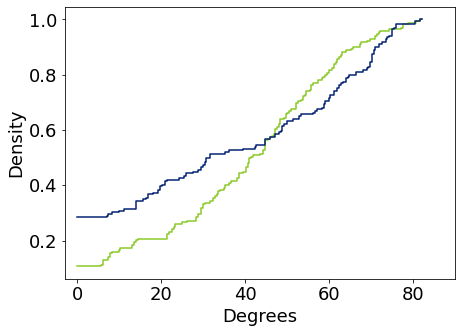

In [33]:
plt.figure(figsize=(7,5))
sns.histplot(
    data=ra_m1, x="degrees", element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, 
    color = m_colors[1], label = "Fixed Network", bins = 200
)

sns.histplot(
    data=ra_m2, x="degrees", element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, 
    color = m_colors[2], label = "Shuffled Network", 
    bins = 200
)
#plt.legend(loc = "upper left")
plt.xlim(-3,90)
plt.xlabel("Degrees")
plt.savefig('./images/cum_ra_m.svg', format='svg', dpi=300, bbox_inches='tight')

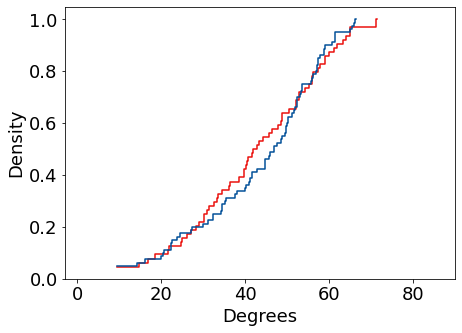

In [34]:
plt.figure(figsize=(7,5))
sns.histplot(
    data=ra_vnN, x="degrees", element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, 
    color = vn_colors["no info"], label = "No Information", bins = 200
)

sns.histplot(
    data=ra_vnI, x="degrees", element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, 
    color = vn_colors["info"], label = "With Information", 
    bins = 200
)
#plt.legend(loc = "upper left")
plt.xlim(-3,90)
plt.xlabel("Degrees")
plt.savefig('./images/cum_ra_vn.svg', format='svg', dpi=300, bbox_inches='tight')

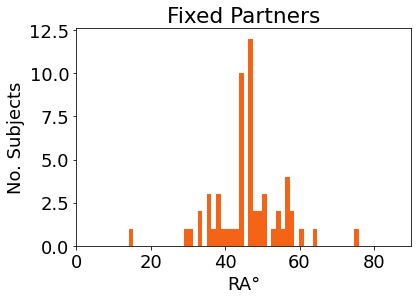

In [35]:
plt.hist(ra_fix.degrees, bins = 50, color = pair_colors["fix"])
plt.xlim(0,90)
plt.title("Fixed Partners")
plt.ylabel("No. Subjects")
plt.xlabel("RA°")
plt.savefig('./images/hist_ra_fix.svg', format='svg', dpi=300, bbox_inches='tight')

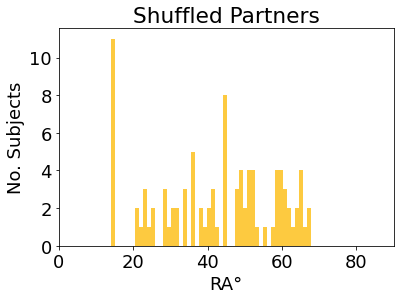

In [36]:
plt.hist(ra_rand.degrees, bins = 50, color = pair_colors["random"])
plt.xlim(0,90)
plt.title("Shuffled Partners")
plt.ylabel("No. Subjects")
plt.xlabel("RA°")
plt.savefig('./images/hist_ra_rand.svg', format='svg', dpi=300, bbox_inches='tight')

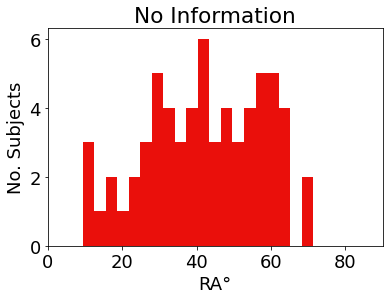

In [37]:
plt.hist(ra_vnN["degrees"], bins = 20, color = vn_colors["no info"])
plt.title("Mean: %f, SD: %f" % (np.mean(ra_vnN["degrees"]), np.std(ra_vnN["degrees"])))
plt.xlim(0,90)
plt.title("No Information")
plt.ylabel("No. Subjects")
plt.xlabel("RA°")
plt.savefig('./images/hist_ra_no_info.svg', format='svg', dpi=300, bbox_inches='tight')

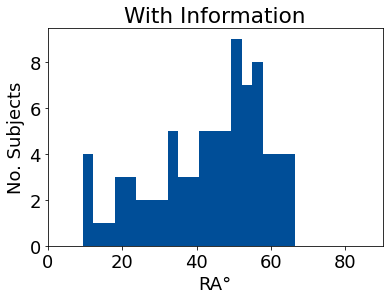

In [38]:
plt.hist(ra_vnI["degrees"], bins = 20, color = vn_colors["info"])
plt.title("Mean: %f, SD: %f" % (np.mean(ra_vnI["degrees"]), np.std(ra_vnI["degrees"])))
plt.xlim(0,90)
plt.title("With Information")
plt.ylabel("No. Subjects")
plt.xlabel("RA°")
plt.savefig('./images/hist_ra_info.svg', format='svg', dpi=300, bbox_inches='tight')

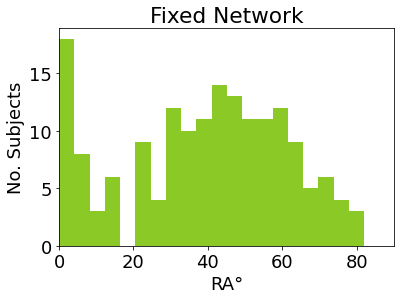

In [39]:
plt.hist(ra_m1["degrees"], bins = 20, color = m_colors[1])
plt.title("Mean: %f, SD: %f" % (np.mean(ra_m1["degrees"]), np.std(ra_m1["degrees"])))
plt.xlim(0,90)
plt.title("Fixed Network")
plt.ylabel("No. Subjects")
plt.xlabel("RA°")
plt.savefig('./images/hist_ra_nFixed.svg', format='svg', dpi=300, bbox_inches='tight')

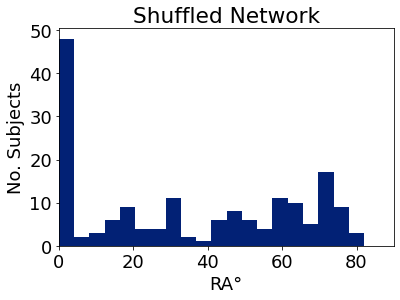

In [40]:
plt.hist(ra_m2["degrees"], bins = 20, color = m_colors[2])
plt.title("Mean: %f, SD: %f" % (np.mean(ra_m2["degrees"]), np.std(ra_m2["degrees"])))
plt.xlim(0,90)
plt.title("Shuffled Network")
plt.ylabel("No. Subjects")
plt.xlabel("RA°")
plt.savefig('./images/hist_ra_nRand.svg', format='svg', dpi=300, bbox_inches='tight')

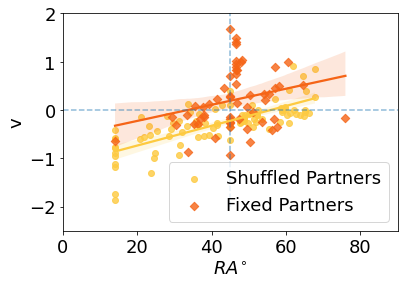

In [41]:
sns.regplot(x=ra_rand.degrees, y=ra_rand.v, marker = pair_symbols["random"], color = pair_colors["random"], label = "Shuffled Partners")
sns.regplot(x=ra_fix.degrees, y=ra_fix.v, color = pair_colors["fix"], marker = pair_symbols["fix"], label = "Fixed Partners")
plt.xlabel(r"$RA^{\circ}$")
plt.hlines(0,0,100, linestyles="dashed", alpha = 0.5)
plt.vlines(45,-2,2, linestyles="dashed", alpha = 0.5)
plt.xlim(0,90)
plt.ylim(-2.5,2)
plt.legend()
plt.savefig('./images/scatter_v_pair.svg', format='svg', dpi=300, bbox_inches='tight')


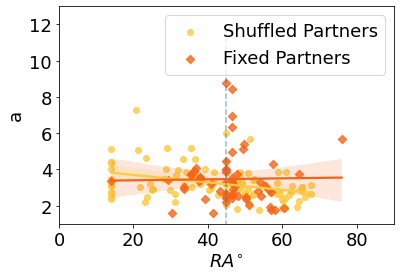

In [42]:
sns.regplot(x=ra_rand.degrees, y=ra_rand.a, marker = pair_symbols["random"], color = pair_colors["random"], label = "Shuffled Partners")
sns.regplot(x=ra_fix.degrees, y=ra_fix.a, color = pair_colors["fix"], marker = pair_symbols["fix"], label = "Fixed Partners")
plt.xlabel(r"$RA^{\circ}$")
plt.vlines(45,0,12, linestyles="dashed", alpha = 0.5)
plt.xlim(0,90)
plt.ylim(1, 13)
plt.legend()
plt.savefig('./images/scatter_a_pair.svg', format='svg', dpi=300, bbox_inches='tight')
            

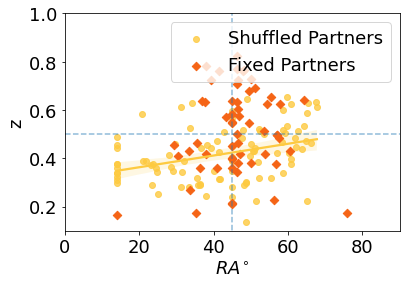

In [43]:
sns.regplot(x=ra_rand.degrees, y=ra_rand.z, marker = pair_symbols["random"], color = pair_colors["random"], label = "Shuffled Partners")
plt.scatter(ra_fix.degrees, ra_fix.z, color = pair_colors["fix"], marker = pair_symbols["fix"], label = "Fixed Partners")
plt.xlabel(r"$RA^{\circ}$")
plt.hlines(0.5,0,100, linestyles="dashed", alpha = 0.5)
plt.vlines(45,-3,2, linestyles="dashed", alpha = 0.5)
plt.xlim(0,90)
plt.ylim(0.1, 1)
plt.legend()
plt.savefig('./images/scatter_z_pair.svg', format='svg', dpi=300, bbox_inches='tight')

In [44]:
display("z: %f, p:%f"% st.spearmanr(ra_fix.degrees, ra_fix.z))
display("v: %f, p:%f"% st.spearmanr(ra_fix.degrees, ra_fix.v))
display("a: %f, p:%f"% st.spearmanr(ra_fix.degrees, ra_fix.a))

'z: 0.167336, p:0.209288'

'v: 0.285949, p:0.029557'

'a: -0.141972, p:0.287744'

In [45]:
display("z: %f, p:%f"% st.spearmanr(ra_rand.degrees, ra_rand.z))
display("v: %f, p:%f"% st.spearmanr(ra_rand.degrees, ra_rand.v))
display("a: %f, p:%f"% st.spearmanr(ra_rand.degrees, ra_rand.a))

'z: 0.383917, p:0.000113'

'v: 0.764860, p:0.000000'

'a: -0.357377, p:0.000351'

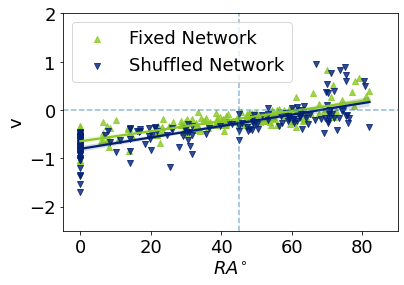

In [46]:
sns.regplot(x=ra_m1.degrees, y=ra_m1.v, marker = m_symbols[1], color = m_colors[1], label = "Fixed Network")
sns.regplot(x=ra_m2.degrees, y=ra_m2.v, marker = m_symbols[2], color = m_colors[2], label = "Shuffled Network")
plt.xlabel(r"$RA^{\circ}$")
plt.hlines(0,-5,100, linestyles="dashed", alpha = 0.5)
plt.vlines(45,-3,2, linestyles="dashed", alpha = 0.5)
plt.xlim(-5,90)
plt.ylim(-2.5,2)
plt.legend()
plt.savefig('./images/scatter_v_nNet.svg', format='svg', dpi=300, bbox_inches='tight')

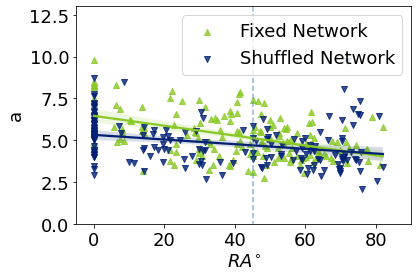

In [47]:
sns.regplot(x=ra_m1.degrees, y=ra_m1.a, marker = m_symbols[1], color = m_colors[1], label = "Fixed Network")
sns.regplot(x=ra_m2.degrees, y=ra_m2.a, marker = m_symbols[2], color = m_colors[2], label = "Shuffled Network")
plt.xlabel(r"$RA^{\circ}$")
plt.vlines(45,-3,13, linestyles="dashed", alpha = 0.5)
plt.xlim(-5,90)
plt.ylim(0, 13)
plt.legend()
plt.savefig('./images/scatter_a_mNet.svg', format='svg', dpi=300, bbox_inches='tight')

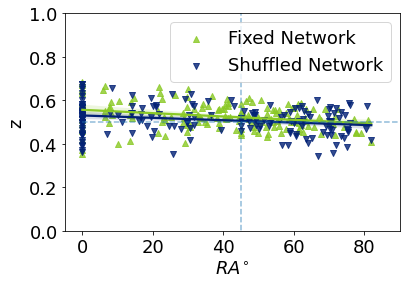

In [48]:
sns.regplot(x=ra_m1.degrees, y=ra_m1.z, marker = m_symbols[1], color = m_colors[1], label = "Fixed Network")
sns.regplot(x=ra_m2.degrees, y=ra_m2.z, marker = m_symbols[2], color = m_colors[2], label = "Shuffled Network")
plt.xlabel(r"$RA^{\circ}$")
plt.vlines(45,-3,2, linestyles="dashed", alpha = 0.5)
plt.hlines(0.5,0,100, linestyles="dashed", alpha = 0.5)
plt.xlim(-5,90)
plt.ylim(0, 1)
plt.legend()
plt.savefig('./images/scatter_z_mNet.svg', format='svg', dpi=300, bbox_inches='tight')

In [49]:
display("z: %f, p:%f"% st.spearmanr(ra_m1.degrees, ra_m1.z))
display("v: %f, p:%f"% st.spearmanr(ra_m1.degrees, ra_m1.v))
display("a: %f, p:%f"% st.spearmanr(ra_m1.degrees, ra_m1.a))

'z: -0.288613, p:0.000142'

'v: 0.840500, p:0.000000'

'a: -0.445414, p:0.000000'

In [50]:
display("z: %f, p:%f"% st.spearmanr(ra_m2.degrees, ra_m2.z))
display("v: %f, p:%f"% st.spearmanr(ra_m2.degrees, ra_m2.v))
display("a: %f, p:%f"% st.spearmanr(ra_m2.degrees, ra_m2.a))

'z: -0.219413, p:0.004154'

'v: 0.864667, p:0.000000'

'a: -0.353731, p:0.000002'

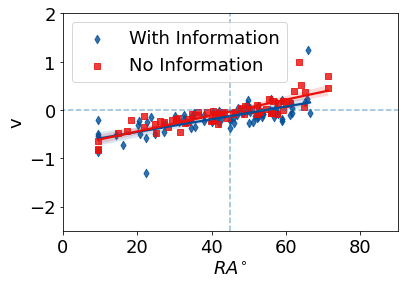

In [51]:
sns.regplot(x=ra_vnI.degrees, y=ra_vnI.v, marker = vn_symbols["info"], color = vn_colors["info"], label = "With Information")
sns.regplot(x=ra_vnN.degrees, y=ra_vnN.v, marker = vn_symbols["no info"], color = vn_colors["no info"], label = "No Information")
plt.xlabel(r"$RA^{\circ}$")
plt.hlines(0,-5,100, linestyles="dashed", alpha = 0.5)
plt.vlines(45,-3,2, linestyles="dashed", alpha = 0.5)
plt.xlim(0,90)
plt.ylim(-2.5,2)
plt.legend()
plt.savefig('./images/scatter_v_vnNet.svg', format='svg', dpi=300, bbox_inches='tight')

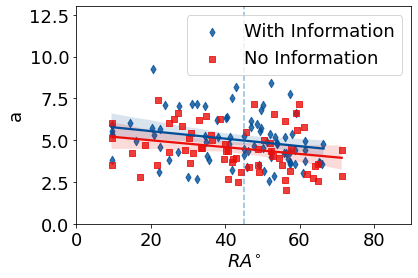

In [52]:
sns.regplot(x=ra_vnI.degrees, y=ra_vnI.a, marker = vn_symbols["info"], color = vn_colors["info"], label = "With Information")
sns.regplot(x=ra_vnN.degrees, y=ra_vnN.a, marker = vn_symbols["no info"], color = vn_colors["no info"], label = "No Information")
plt.xlabel(r"$RA^{\circ}$")
plt.vlines(45,0,13, linestyles="dashed", alpha = 0.5)
plt.xlim(0,90)
plt.ylim(0,13)
plt.legend()
plt.savefig('./images/scatter_a_vnNet.svg', format='svg', dpi=300, bbox_inches='tight')

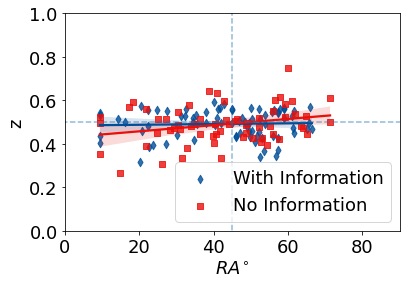

In [53]:
sns.regplot(x=ra_vnI.degrees, y=ra_vnI.z, marker = vn_symbols["info"], color = vn_colors["info"], label = "With Information")
sns.regplot(x=ra_vnN.degrees, y=ra_vnN.z, marker = vn_symbols["no info"], color = vn_colors["no info"], label = "No Information")
plt.xlabel(r"$RA^{\circ}$")
plt.hlines(0.5,-5,100, linestyles="dashed", alpha = 0.5)
plt.vlines(45,-3,2, linestyles="dashed", alpha = 0.5)
plt.xlim(0,90)
plt.ylim(0,1)
plt.legend()
plt.savefig('./images/scatter_z_vnNet.svg', format='svg', dpi=300, bbox_inches='tight')

In [54]:
display("z: %f, p:%f"% st.spearmanr(ra_vnI.degrees, ra_vnI.z))
display("v: %f, p:%f"% st.spearmanr(ra_vnI.degrees, ra_vnI.v))
display("a: %f, p:%f"% st.spearmanr(ra_vnI.degrees, ra_vnI.a))

'z: 0.011628, p:0.918464'

'v: 0.724813, p:0.000000'

'a: -0.302263, p:0.006430'

In [55]:
display("z: %f, p:%f"% st.spearmanr(ra_vnN.degrees, ra_vnN.z))
display("v: %f, p:%f"% st.spearmanr(ra_vnN.degrees, ra_vnN.v))
display("a: %f, p:%f"% st.spearmanr(ra_vnN.degrees, ra_vnN.a))

'z: 0.194622, p:0.123300'

'v: 0.897217, p:0.000000'

'a: -0.280933, p:0.024534'

In [56]:
display("M = %0.4f, SD = %0.4f" % (ra_fix.degrees.mean(), ra_fix.degrees.std()))
display("M = %0.4f, SD = %0.4f" % (ra_rand.degrees.mean(), ra_rand.degrees.std()))
display("M = %0.4f, SD = %0.4f" % (ra_vnN.degrees.mean(), ra_vnN.degrees.std()))
display("M = %0.4f, SD = %0.4f" % (ra_vnI.degrees.mean(), ra_vnI.degrees.std()))
display("M = %0.4f, SD = %0.4f" % (ra_m1.degrees.mean(), ra_m1.degrees.std()))
display("M = %0.4f, SD = %0.4f" % (ra_m2.degrees.mean(), ra_m2.degrees.std()))

'M = 46.2055, SD = 9.4865'

'M = 42.3099, SD = 16.1744'

'M = 42.3737, SD = 15.7977'

'M = 43.2187, SD = 15.1973'

'M = 39.1687, SD = 22.2905'

'M = 34.8114, SD = 28.5704'

In [59]:
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_fix.degrees, ra_rand.degrees, alternative = "two-sided")))
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_m1.degrees, ra_m2.degrees, alternative = "two-sided")))
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_vnI.degrees, ra_vnN.degrees, alternative = "two-sided")))

'KS statistic $D = 0.2504$, p-value = $0.0170$'

'KS statistic $D = 0.2071$, p-value = $0.0014$'

'KS statistic $D = 0.1219$, p-value = $0.6238$'

In [60]:
display("M = %0.4f, SD = %0.4f" % (ra_fix.a.mean(), ra_fix.a.std()))
display("M = %0.4f, SD = %0.4f" % (ra_rand.a.mean(), ra_rand.a.std()))
display("M = %0.4f, SD = %0.4f" % (ra_m1.a.mean(), ra_m1.a.std()))
display("M = %0.4f, SD = %0.4f" % (ra_m2.a.mean(), ra_m2.a.std()))
display("M = %0.4f, SD = %0.4f" % (ra_vnN.a.mean(), ra_vnN.a.std()))
display("M = %0.4f, SD = %0.4f" % (ra_vnI.a.mean(), ra_vnI.a.std()))

'M = 3.4712, SD = 1.4797'

'M = 3.2377, SD = 0.9637'

'M = 5.2962, SD = 1.3608'

'M = 4.8317, SD = 1.2987'

'M = 4.5371, SD = 1.3376'

'M = 5.0195, SD = 1.4433'

In [61]:
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_fix.a, ra_rand.a, alternative = "two-sided")))
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_m1.a, ra_m2.a, alternative = "two-sided")))
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_vnI.a, ra_vnN.a, alternative = "two-sided")))



'KS statistic $D = 0.1354$, p-value = $0.4711$'

'KS statistic $D = 0.1657$, p-value = $0.0192$'

'KS statistic $D = 0.1750$, p-value = $0.2025$'

In [62]:
display("M = %0.4f, SD = %0.4f" % (ra_fix.v.mean(), ra_fix.v.std()))
display("M = %0.4f, SD = %0.4f" % (ra_rand.v.mean(), ra_rand.v.std()))
display("M = %0.4f, SD = %0.4f" % (ra_m1.v.mean(), ra_m1.v.std()))
display("M = %0.4f, SD = %0.4f" % (ra_m2.v.mean(), ra_m2.v.std()))
display("M = %0.4f, SD = %0.4f" % (ra_vnN.v.mean(), ra_vnN.v.std()))
display("M = %0.4f, SD = %0.4f" % (ra_vnI.v.mean(), ra_vnI.v.std()))

'M = 0.2109, SD = 0.6102'

'M = -0.2784, SD = 0.4446'

'M = -0.2393, SD = 0.2834'

'M = -0.3926, SD = 0.4310'

'M = -0.0756, SD = 0.3035'

'M = -0.1492, SD = 0.2907'

In [63]:
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_fix.v, ra_rand.v, alternative = "two-sided")))
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_m1.v, ra_m2.v, alternative = "two-sided")))
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_vnI.v, ra_vnN.v, alternative = "two-sided")))


'KS statistic $D = 0.4267$, p-value = $0.0000$'

'KS statistic $D = 0.3077$, p-value = $0.0000$'

'KS statistic $D = 0.1906$, p-value = $0.1333$'

In [64]:
display("M = %0.4f, SD = %0.4f" % (ra_fix.z.mean(), ra_fix.z.std()))
display("M = %0.4f, SD = %0.4f" % (ra_rand.z.mean(), ra_rand.z.std()))
display("M = %0.4f, SD = %0.4f" % (ra_m1.z.mean(), ra_m1.z.std()))
display("M = %0.4f, SD = %0.4f" % (ra_m2.z.mean(), ra_m2.z.std()))
display("M = %0.4f, SD = %0.4f" % (ra_vnN.z.mean(), ra_vnN.z.std()))
display("M = %0.4f, SD = %0.4f" % (ra_vnI.z.mean(), ra_vnI.z.std()))

'M = 0.5105, SD = 0.1734'

'M = 0.4172, SD = 0.1130'

'M = 0.5264, SD = 0.0611'

'M = 0.5114, SD = 0.0667'

'M = 0.4893, SD = 0.0853'

'M = 0.4916, SD = 0.0640'

In [65]:
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_fix.z, ra_rand.z, alternative = "two-sided")))
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_m1.z, ra_m2.z, alternative = "two-sided")))
display("KS statistic $D = %0.4f$, p-value = $%0.4f$" % (st.kstest(ra_vnI.z, ra_vnN.z, alternative = "two-sided")))

'KS statistic $D = 0.3301$, p-value = $0.0005$'

'KS statistic $D = 0.1243$, p-value = $0.1472$'

'KS statistic $D = 0.1500$, p-value = $0.3654$'

In [66]:
display(st.mannwhitneyu(ra_vnI.a, ra_fix.a, alternative = "greater"))
display(st.mannwhitneyu(ra_vnN.a, ra_rand.a, alternative = "greater"))

MannwhitneyuResult(statistic=3781.0, pvalue=1.4902847393970783e-10)

MannwhitneyuResult(statistic=4860.0, pvalue=2.394874805823604e-10)

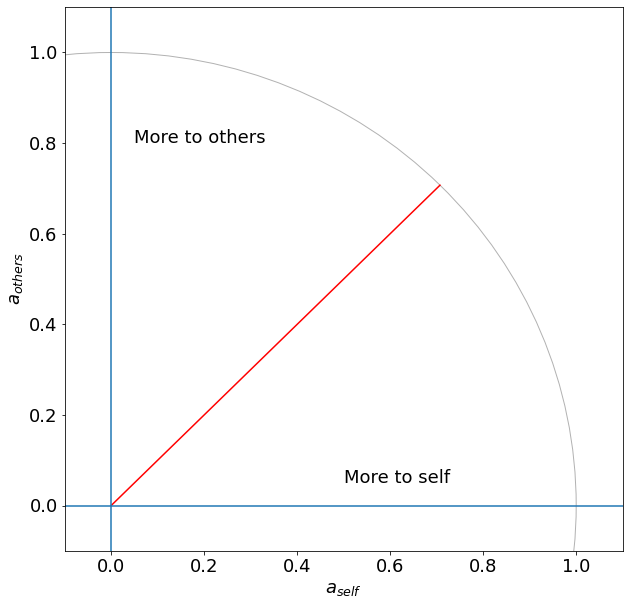

In [67]:
circle1 = plt.Circle((0, 0), 1, color='black', fill=False, alpha = 0.3)


sub = 0
plt.figure(figsize=(10,10))
plt.xlabel(r"$a_{self}$")
plt.ylabel(r"$a_{others}$")

plt.ylim(-0.1,1.1)
plt.xlim(-0.1,1.1)
plt.plot((0,0.707), (0,0.707), 'k-', color = 'r')
#plt.annotate("Equality-seeking", (0.707, 0.707))
plt.annotate("More to self", (0.5, 0.05))
#plt.annotate(r"$max(a_{self}), min(a_{others})$", (0.69, 0.05)) 
#plt.annotate(r"$min(a_{self}), max(a_{others})$", (0.001, 0.99))
#plt.annotate(r"$a_{self} \approx a_{others}$", (0.75, 0.65))
plt.annotate("More to others", (0.05, 0.8))
plt.plot((0,2.82), (2.82,2.82), "-", alpha = 0.4, color = "blue")
plt.plot((2.82,2.82), (0,2.82), "-", alpha = 0.4, color = "blue")
plt.scatter(0,4, color = "blue")
plt.scatter(4,0, color = "blue")
plt.gca().add_patch(circle1)
plt.vlines(0,-5,5)
plt.hlines(0,-5,5)
plt.savefig('./images/polar_example.svg', format='svg', dpi=300, bbox_inches='tight')

[Text(0, 0.1, ''),
 Text(0, 0.2, ''),
 Text(0, 0.30000000000000004, ''),
 Text(0, 0.4, ''),
 Text(0, 0.5, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.7000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 0.9, '')]

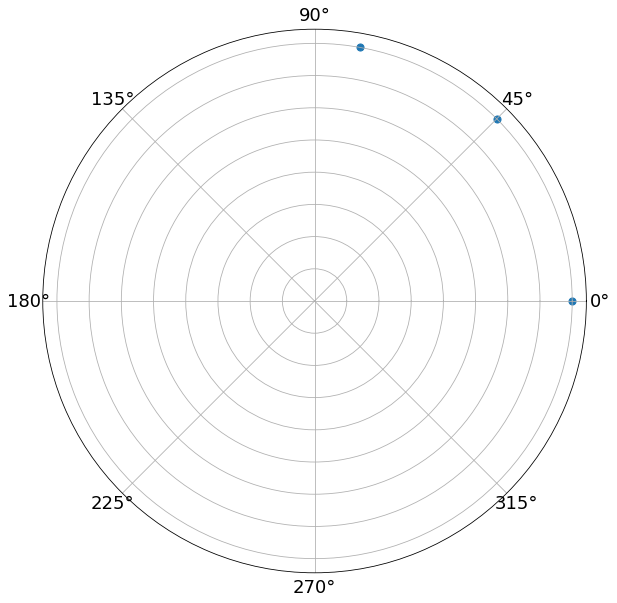

In [68]:
r_ex, theta_ex = cart2pol([3, 4, 14], [3, 0, 78], 0.2)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='polar')
ax.scatter(theta_ex, r_ex, s = 50)
ax.set_yticklabels([])
#plt.legend(loc = (0.45,0.49))

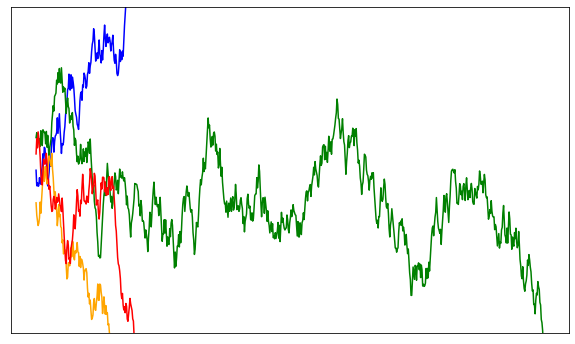

In [69]:
rw1 = [0.5]
rw2 = [0.6]
rw3 = [0.4]
rw4 = [0.55]

def random_walk(rw):
    for i in range(1, 10000):
        s = rw[i - 1] + np.random.uniform(-0.05, 0.05)
        rw.append(s)
        if s >= 1 or s <= 0:
            break
    return rw, i
plt.figure(figsize=(10,6))
plt.plot(random_walk(rw1)[0], color = "blue")
plt.plot(random_walk(rw2)[0], color = "green")
plt.plot(random_walk(rw3)[0], color = "orange")
plt.plot(random_walk(rw4)[0], color = "red")
plt.ylim(0,1)
plt.yticks([])
plt.xticks([])
plt.savefig('./images/random_walk.svg', format='svg', dpi=300, bbox_inches='tight')

In [70]:
times = []
for i in range(10000):
    times.append(random_walk([np.random.uniform(0.3, 0.7)])[1])


Text(0, 0.5, '')

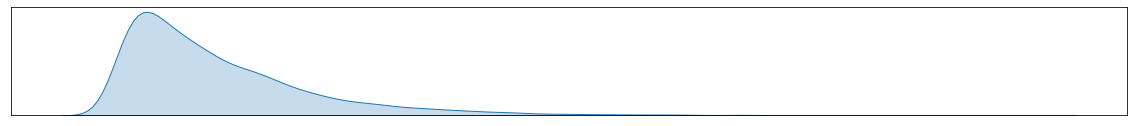

In [71]:
plt.figure(figsize=(20, 2))
sns.kdeplot(times, fill = True)
plt.yticks([])
plt.xticks([])
plt.ylabel("")

Text(0, 0.5, '')

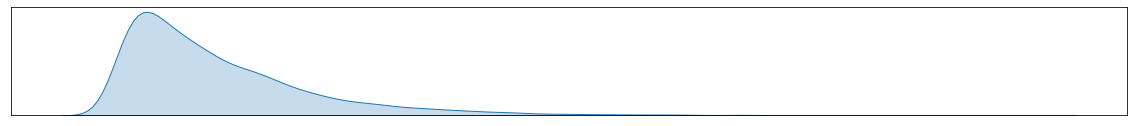

In [72]:
plt.figure(figsize=(20, 2))
sns.kdeplot(times, fill = True)
plt.yticks([])
plt.xticks([])
plt.ylabel("")

# Test for conciseness 

In [1179]:
p_data_f2 = p_data_f
p_data_c2 = p_data_c

In [1180]:
m_data_12 = m_data_1
m_data_22 = m_data_2

In [1181]:
vn_data_i2 = vn_data_i
vn_data_n2 = vn_data_n

In [1182]:
#p_data_f2.context = np.round(np.random.random_sample(5800),0)
#p_data_c2.context = np.round(np.random.random_sample(9600),0)

p_data_f2.response = np.round(np.random.random_sample(5800),0)
p_data_c2.response = np.round(np.random.random_sample(9600),0)

In [1183]:
#vn_data_i2.context = np.round(np.random.random_sample(len(vn_data_i2)) * 4,0)
#vn_data_n2.context = np.round(np.random.random_sample(len(vn_data_n2)) * 4,0)

vn_data_i2.response = np.round(np.random.random_sample(len(vn_data_i2)))
vn_data_n2.response = np.round(np.random.random_sample(len(vn_data_n2)))

In [1184]:
m_data_12.response = np.round(np.random.random_sample(len(m_data_12)))
m_data_22.response = np.round(np.random.random_sample(len(m_data_22)))

#m_data_12.context = np.round(np.random.random_sample(len(m_data_12)) * 6, 0)
#m_data_22.context = np.round(np.random.random_sample(len(m_data_22)) * 6, 0)

In [1185]:
p_data_f2 = get_RA(p_data_f2,1,3.0,4.0,1.0,0.0)
p_data_c2 = get_RA(p_data_c2,1,3.0,4.0,1.0,0.0)

In [1186]:
m_data_12 = get_RA(m_data_12,8,7.0,10.0,0.0,0.0)
m_data_22 = get_RA(m_data_22,8,7.0,10.0,0.0,0.0)

In [1187]:
vn_data_i2 = get_RA(vn_data_i2,4,5.0,6.0,1.0,0.0)
vn_data_n2 = get_RA(vn_data_n2,4,5.0,6.0,1.0,0.0)

In [1188]:
ra_fix2 = pd.pivot_table(p_data_f2.loc[p_data_f2["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)
ra_rand2 = pd.pivot_table(p_data_c2.loc[p_data_c2["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)

In [1189]:
ra_m12 = pd.pivot_table(m_data_12.loc[m_data_12["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)
ra_m22 = pd.pivot_table(m_data_22.loc[m_data_22["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)

In [1190]:
ra_vnI2 = pd.pivot_table(vn_data_i2.loc[vn_data_i2["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)
ra_vnN2 = pd.pivot_table(vn_data_n2.loc[vn_data_n2["round"] <= 20], values=["self", "other"], index=["user_id"], aggfunc=np.mean)

In [1191]:
ra_fix2["degrees"] = np.arctan((ra_fix2["other"] / ra_fix2["self"]) ) * 180.0 / math.pi
ra_rand2["degrees"] = np.arctan((ra_rand2["other"] / ra_rand2["self"]) ) * 180.0 / math.pi

In [1192]:
ra_m12["degrees"] = np.arctan((ra_m12["other"] / ra_m12["self"]) ) * 180.0 / math.pi
ra_m22["degrees"] = np.arctan((ra_m22["other"] / ra_m22["self"]) ) * 180.0 / math.pi

In [1193]:
ra_vnI2["degrees"] = np.arctan((ra_vnI2["other"] / ra_vnI2["self"]) ) * 180.0 / math.pi
ra_vnN2["degrees"] = np.arctan((ra_vnN2["other"] / ra_vnN2["self"]) ) * 180.0 / math.pi

In [1194]:
ra_fix2 = ra_fix2.merge(ddm_fix, on= "user_id")
ra_rand2 = ra_rand2.merge(ddm_rand, on= "user_id")

In [1195]:
ra_m12 = ra_m12.merge(ddm_m1, on= "user_id")
ra_m22 = ra_m22.merge(ddm_m2, on= "user_id")

In [1196]:
ra_vnI2 = ra_vnI2.merge(ddm_vn, on= "user_id")
ra_vnN2 = ra_vnN2.merge(ddm_vn, on= "user_id")

Text(0.5, 1.0, 'SpearmanrResult(correlation=0.08189332446361851, pvalue=0.5411121319857597)')

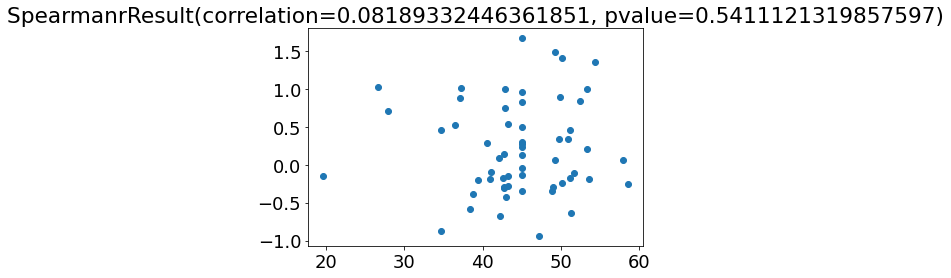

In [1197]:
plt.scatter(ra_fix2.degrees, ra_fix2.v)
plt.title(st.spearmanr(ra_fix2.degrees, ra_fix2.v))


Text(0.5, 1.0, 'SpearmanrResult(correlation=0.15417419170596605, pvalue=0.1336695642632725)')

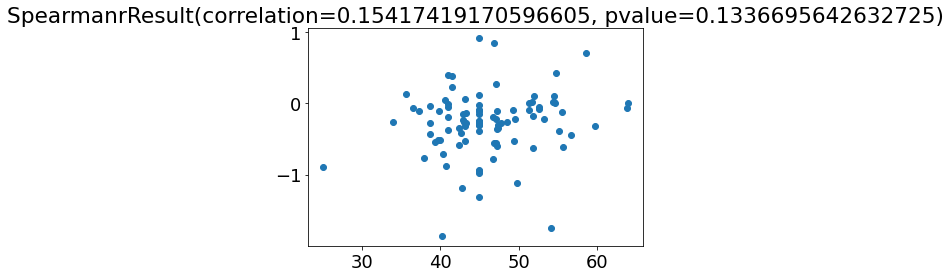

In [1198]:
plt.scatter(ra_rand2.degrees, ra_rand2.v)
plt.title(st.spearmanr(ra_rand2.degrees, ra_rand2.v))

Text(0.5, 1.0, 'SpearmanrResult(correlation=0.022298811281282416, pvalue=0.7735236559727185)')

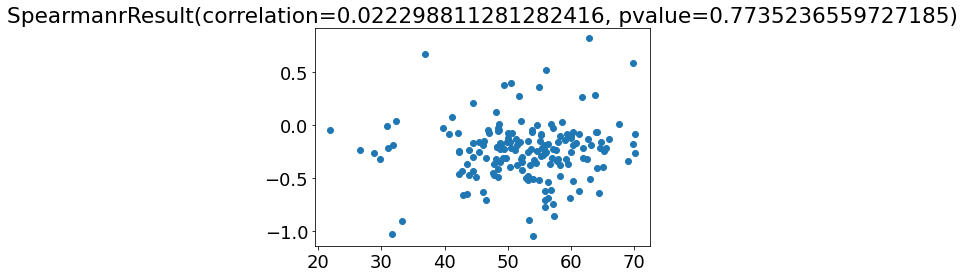

In [1199]:
plt.scatter(ra_m12.degrees, ra_m12.v)
plt.title(st.spearmanr(ra_m12.degrees, ra_m12.v))

Text(0.5, 1.0, 'SpearmanrResult(correlation=-0.06608296123264427, pvalue=0.5602981739516305)')

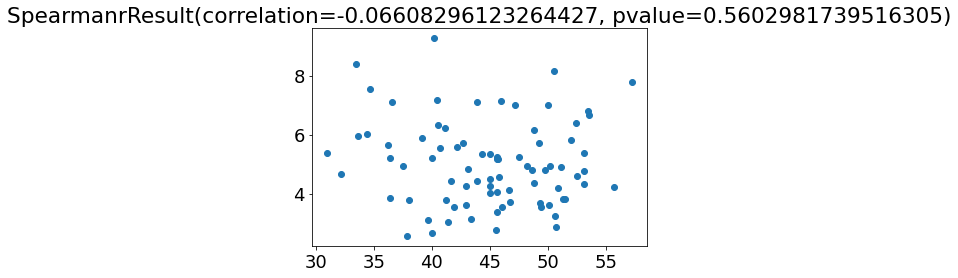

In [1200]:
plt.scatter(ra_vnI2.degrees, ra_vnI2.a)
plt.title(st.spearmanr(ra_vnI2.degrees, ra_vnI2.a))

In [1201]:
display("%0.4f, %0.4f" %  (st.spearmanr(ra_fix2.degrees, ra_fix2.a)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_fix2.degrees, ra_fix2.v)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_fix2.degrees, ra_fix2.z)))


'0.0386, 0.7737'

'0.0819, 0.5411'

'-0.0098, 0.9419'

In [1202]:
display("%0.4f, %0.4f" %  (st.spearmanr(ra_rand2.degrees, ra_rand2.a)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_rand2.degrees, ra_rand2.v)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_rand2.degrees, ra_rand2.z)))

'-0.1270, 0.2174'

'0.1542, 0.1337'

'0.1348, 0.1903'

In [1203]:
display("%0.4f, %0.4f" %  (st.spearmanr(ra_m12.degrees, ra_m12.a)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_m12.degrees, ra_m12.v)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_m12.degrees, ra_m12.z)))

'-0.0935, 0.2268'

'0.0223, 0.7735'

'0.0073, 0.9247'

In [1204]:
display("%0.4f, %0.4f" %  (st.spearmanr(ra_m22.degrees, ra_m22.a)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_m22.degrees, ra_m22.v)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_m22.degrees, ra_m22.z)))

'-0.0940, 0.2243'

'-0.0127, 0.8698'

'0.0462, 0.5513'

In [1205]:
display("%0.4f, %0.4f" %  (st.spearmanr(ra_vnN2.degrees, ra_vnN2.a)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_vnN2.degrees, ra_vnN2.v)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_vnN2.degrees, ra_vnN2.z)))

'-0.2441, 0.0519'

'-0.0807, 0.5261'

'-0.1116, 0.3800'

In [1206]:
display("%0.4f, %0.4f" %  (st.spearmanr(ra_vnI2.degrees, ra_vnI2.a)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_vnI2.degrees, ra_vnI2.v)))
display("%0.4f, %0.4f" %  (st.spearmanr(ra_vnI2.degrees, ra_vnI2.z)))

'-0.0661, 0.5603'

'0.1474, 0.1920'

'-0.1236, 0.2746'

In [143]:
#Rationality Measure
ra_fix["c_teo"] = ra_fix.apply(lambda row : 1 / (1 + math.exp(-1 * row.a * row.v)) , axis = 1)
coop = p_data_f.groupby("user_id").response.sum() / p_data_f["round"].max()
coop = coop.reset_index()
ra_fix = ra_fix.merge(coop, on="user_id")
ra_fix["rat"] = ra_fix.apply(lambda row : (np.abs(row.c_teo - 0.5) / (np.abs(row.c_teo - 0.5) + np.abs(row.response - row.c_teo)) ) , axis = 1)


In [144]:
ra_rand["c_teo"] = ra_rand.apply(lambda row : 1 / (1 + math.exp(-1 * row.a * row.v)) , axis = 1)
coop = p_data_c.groupby("user_id").response.sum() / p_data_c["round"].max()
coop = coop.reset_index()
ra_rand = ra_rand.merge(coop, on="user_id")
ra_rand["rat"] = ra_rand.apply(lambda row : (np.abs(row.c_teo - 0.5) / (np.abs(row.c_teo - 0.5) + np.abs(row.response - row.c_teo)) ) , axis = 1)


Text(0.5, 1.0, 'SpearmanrResult(correlation=-0.6265599565925123, pvalue=8.601816834111465e-12)')

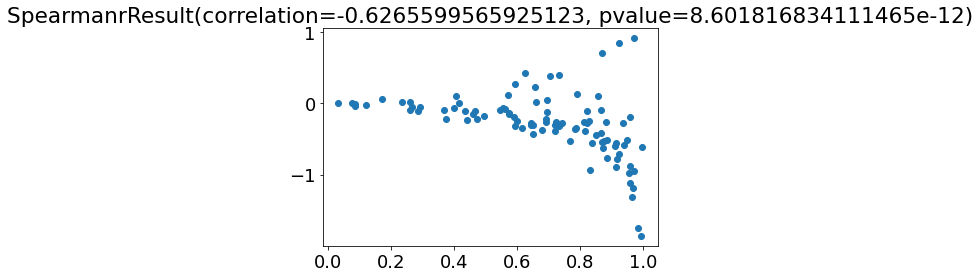

In [146]:
plt.scatter(ra_rand.rat, ra_rand.v)
plt.title(st.spearmanr(ra_rand.rat, ra_rand.v))

In [147]:
ra_vnI["c_teo"] = ra_vnI.apply(lambda row : 1 / (1 + math.exp(-1 * row.a * row.v)) , axis = 1)
coop = vn_data_i.groupby("user_id").response.sum() / vn_data_i["round"].max()
coop = coop.reset_index()
ra_vnI = ra_vnI.merge(coop, on="user_id")
ra_vnI["rat"] = ra_vnI.apply(lambda row : (np.abs(row.c_teo - 0.5) / (np.abs(row.c_teo - 0.5) + np.abs(row.response - row.c_teo)) ) , axis = 1)


In [149]:
ra_vnN["c_teo"] = ra_vnN.apply(lambda row : 1 / (1 + math.exp(-1 * row.a * row.v)) , axis = 1)
coop = vn_data_n.groupby("user_id").response.sum() / vn_data_n["round"].max()
coop = coop.reset_index()
ra_vnN = ra_vnN.merge(coop, on="user_id")
ra_vnN["rat"] = ra_vnN.apply(lambda row : (np.abs(row.c_teo - 0.5) / (np.abs(row.c_teo - 0.5) + np.abs(row.response - row.c_teo)) ) , axis = 1)


In [151]:
ra_m1["c_teo"] = ra_m1.apply(lambda row : 1 / (1 + math.exp(-1 * row.a * row.v)) , axis = 1)
coop = m_data_1.groupby("user_id").response.sum() / m_data_1["round"].max()
coop = coop.reset_index()
ra_m1 = ra_m1.merge(coop, on="user_id")
ra_m1["rat"] = ra_m1.apply(lambda row : (np.abs(row.c_teo - 0.5) / (np.abs(row.c_teo - 0.5) + np.abs(row.response - row.c_teo)) ) , axis = 1)


In [152]:
ra_m2["c_teo"] = ra_m2.apply(lambda row : 1 / (1 + math.exp(-1 * row.a * row.v)) , axis = 1)
coop = m_data_2.groupby("user_id").response.sum() / m_data_2["round"].max()
coop = coop.reset_index()
ra_m2 = ra_m2.merge(coop, on="user_id")
ra_m2["rat"] = ra_m2.apply(lambda row : (np.abs(row.c_teo - 0.5) / (np.abs(row.c_teo - 0.5) + np.abs(row.response - row.c_teo)) ) , axis = 1)


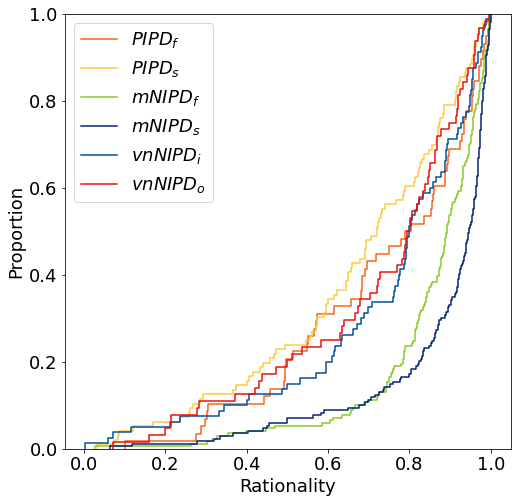

In [197]:
plt.figure(figsize = (8,8))
sns.ecdfplot(data=ra_fix, x="rat", label = r"$PIPD_f$", color = pair_colors["fix"])
sns.ecdfplot(data=ra_rand, x="rat", label = r"$PIPD_s$", color = pair_colors["random"])
sns.ecdfplot(data=ra_m1, x="rat", label = r"$mNIPD_f$", color = m_colors[1])
sns.ecdfplot(data=ra_m2, x="rat", label = r"$mNIPD_s$", color = m_colors[2])
sns.ecdfplot(data=ra_vnI, x="rat", label = r"$vnNIPD_i$", color = vn_colors["info"])
sns.ecdfplot(data=ra_vnN, x="rat", label = r"$vnNIPD_o$", color = vn_colors["no info"])
plt.xlabel("Rationality")
plt.legend()

plt.savefig('./images/rationality.svg', format='svg', dpi=300, bbox_inches='tight')

In [204]:
st.kstest(ra_m1.rat, ra_fix.rat, alternative = "two-sided")

KstestResult(statistic=0.3358498265660069, pvalue=7.64283433328794e-05)

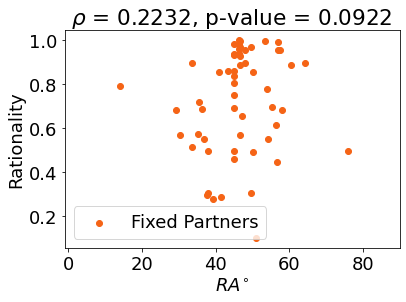

In [238]:
plt.scatter(ra_fix.degrees, ra_fix.rat, color = pair_colors["fix"], label = "Fixed Partners")
plt.title(r"$\rho$ = %0.4f, p-value = %0.4f" % (st.spearmanr(ra_fix.degrees, ra_fix.rat)))
plt.ylabel("Rationality")
plt.xlabel(r"$RA^{\circ}$")
plt.xlim(-1, 90)
plt.legend()
plt.savefig('./images/rat_fix.svg', format='svg', dpi=300, bbox_inches='tight')

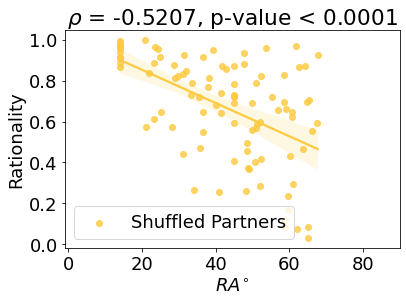

In [237]:
sns.regplot(ra_rand.degrees, ra_rand.rat, color = pair_colors["random"], label = "Shuffled Partners")
plt.title(r"$\rho$ = %0.4f, p-value < 0.0001" % (st.spearmanr(ra_rand.degrees, ra_rand.rat)[0]))
plt.ylabel("Rationality")
plt.xlabel(r"$RA^{\circ}$")
plt.xlim(-1, 90)
plt.legend()
plt.savefig('./images/rat_rand.svg', format='svg', dpi=300, bbox_inches='tight')

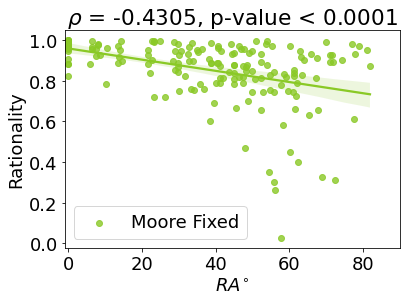

In [239]:
sns.regplot(ra_m1.degrees, ra_m1.rat, color = m_colors[1], label = "Moore Fixed")
plt.title(r"$\rho$ = %0.4f, p-value < 0.0001" % (st.spearmanr(ra_m1.degrees, ra_m1.rat)[0]))
plt.ylabel("Rationality")
plt.xlabel(r"$RA^{\circ}$")
plt.xlim(-1, 90)
plt.legend()
plt.savefig('./images/rat_m1.svg', format='svg', dpi=300, bbox_inches='tight')

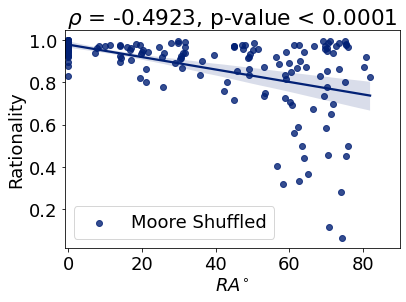

In [240]:
sns.regplot(ra_m2.degrees, ra_m2.rat, color = m_colors[2], label = "Moore Shuffled")
plt.title(r"$\rho$ = %0.4f, p-value < 0.0001" % (st.spearmanr(ra_m2.degrees, ra_m2.rat)[0]))
plt.ylabel("Rationality")
plt.xlabel(r"$RA^{\circ}$")
plt.xlim(-1, 90)
plt.legend()
plt.savefig('./images/rat_m2.svg', format='svg', dpi=300, bbox_inches='tight')

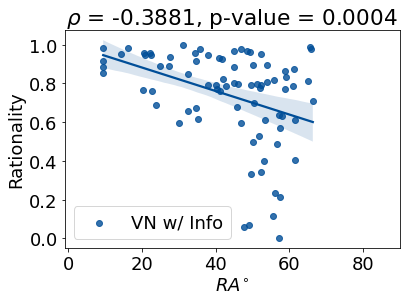

In [242]:
sns.regplot(ra_vnI.degrees, ra_vnI.rat, color = vn_colors["info"], label = "VN w/ Info")
plt.title(r"$\rho$ = %0.4f, p-value = %0.4f" % (st.spearmanr(ra_vnI.degrees, ra_vnI.rat)))
plt.ylabel("Rationality")
plt.xlabel(r"$RA^{\circ}$")
plt.xlim(-1, 90)
plt.legend()
plt.savefig('./images/rat_vnI.svg', format='svg', dpi=300, bbox_inches='tight')

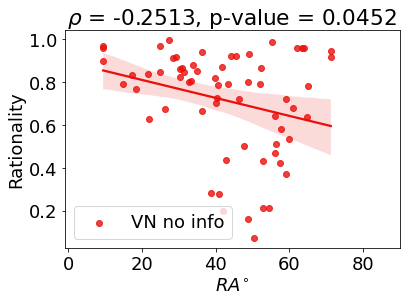

In [247]:
sns.regplot(ra_vnN.degrees, ra_vnN.rat, color = vn_colors["no info"], label = "VN no info")
plt.title(r"$\rho$ = %0.4f, p-value = %0.4f" %  (st.spearmanr(ra_vnN.degrees, ra_vnN.rat)))
plt.ylabel("Rationality")
plt.xlabel(r"$RA^{\circ}$")
plt.xlim(-1, 90)
plt.legend(loc = "lower left")
plt.savefig('./images/rat_vnN.svg', format='svg', dpi=300, bbox_inches='tight')

In [248]:
len("Fast deliberation leads to unconditional behavior. Analysis of intuitive and reflective processes of other-regarding preferences")

128